In [1]:
import ete3
import os
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import combinations, product
from matplotlib import pyplot as plt
from Bio import AlignIO
import re
import multiprocessing
import subprocess
import matplotlib.colors
#import plotly
#import plotly.plotly as ptl
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

%cd /work/site_rate/hug_et_al

/work/site_rate/hug_et_al


In [2]:
alignment = []
headers   = []
for sequence in AlignIO.read('ribosomal_concat.fasta', format='fasta'):
    alignment.append(list(sequence.seq))
    headers.append(sequence.name)
alignment = np.asarray(alignment)

In [3]:
rates = pd.read_table('rate_binning.rate', comment='#')
threshold_cat  = 10

number_of_gaps = []
well_aligned   = []
bad_aligned    = []
all_columns    = []
for (index, row), (column, site) in zip(rates.iterrows(), enumerate(alignment.T)):
    number_of_gaps.append(sum(site=='-'))
    if row.Cat < threshold_cat:
        continue
    
    all_columns.append(column)
    if sum(alignment[:,column-1]=='-') <= 500 and sum(alignment[:,column+1]=='-') <= 500:
        well_aligned.append(column)
    elif sum(alignment[:,column-1]=='-') >= 2000 and sum(alignment[:,column+1]=='-') >= 2000:
        bad_aligned.append(column)
number_of_gaps = np.asarray(number_of_gaps)

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

read_table is deprecated, use read_csv instead, passing sep='\t'.



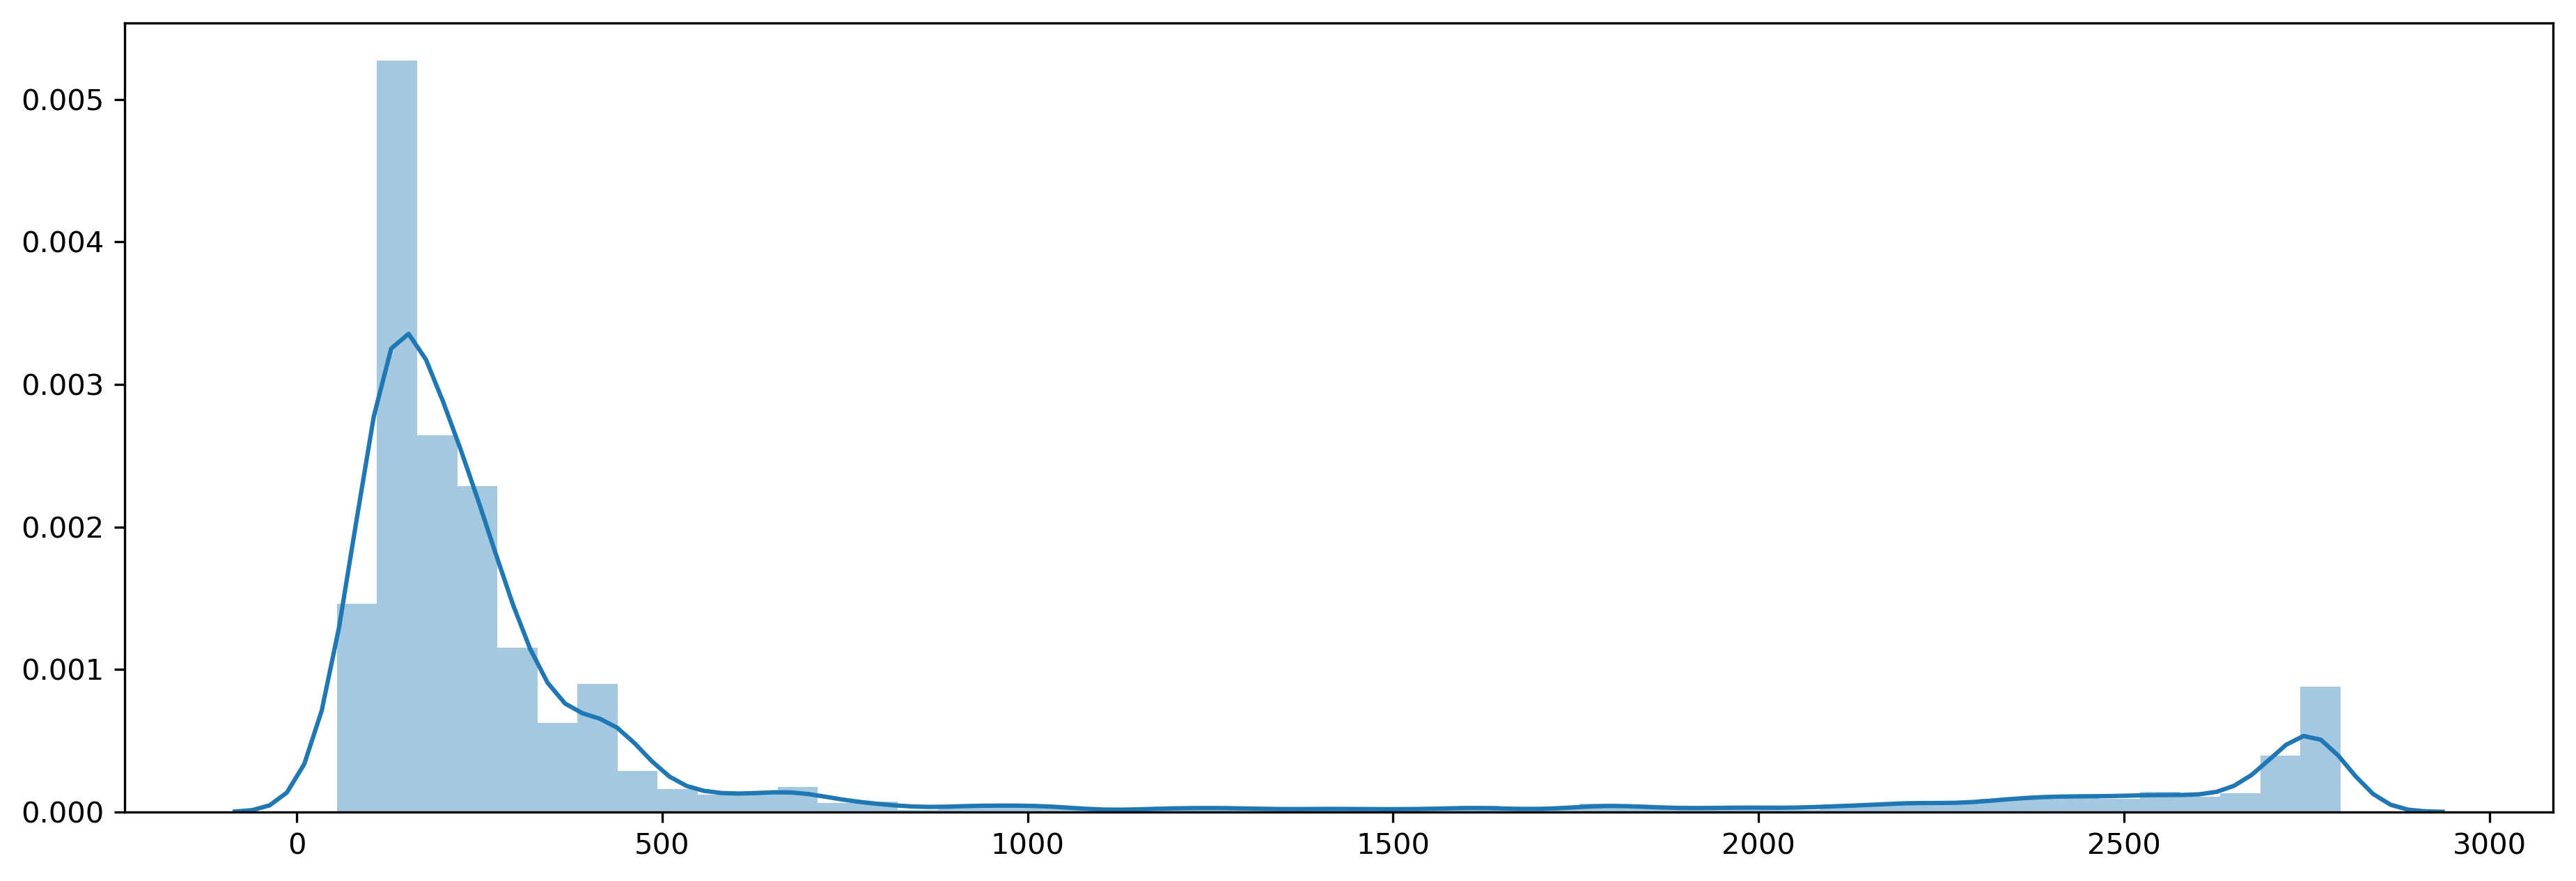

In [4]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
sns.distplot(number_of_gaps, ax=ax, bins=50)

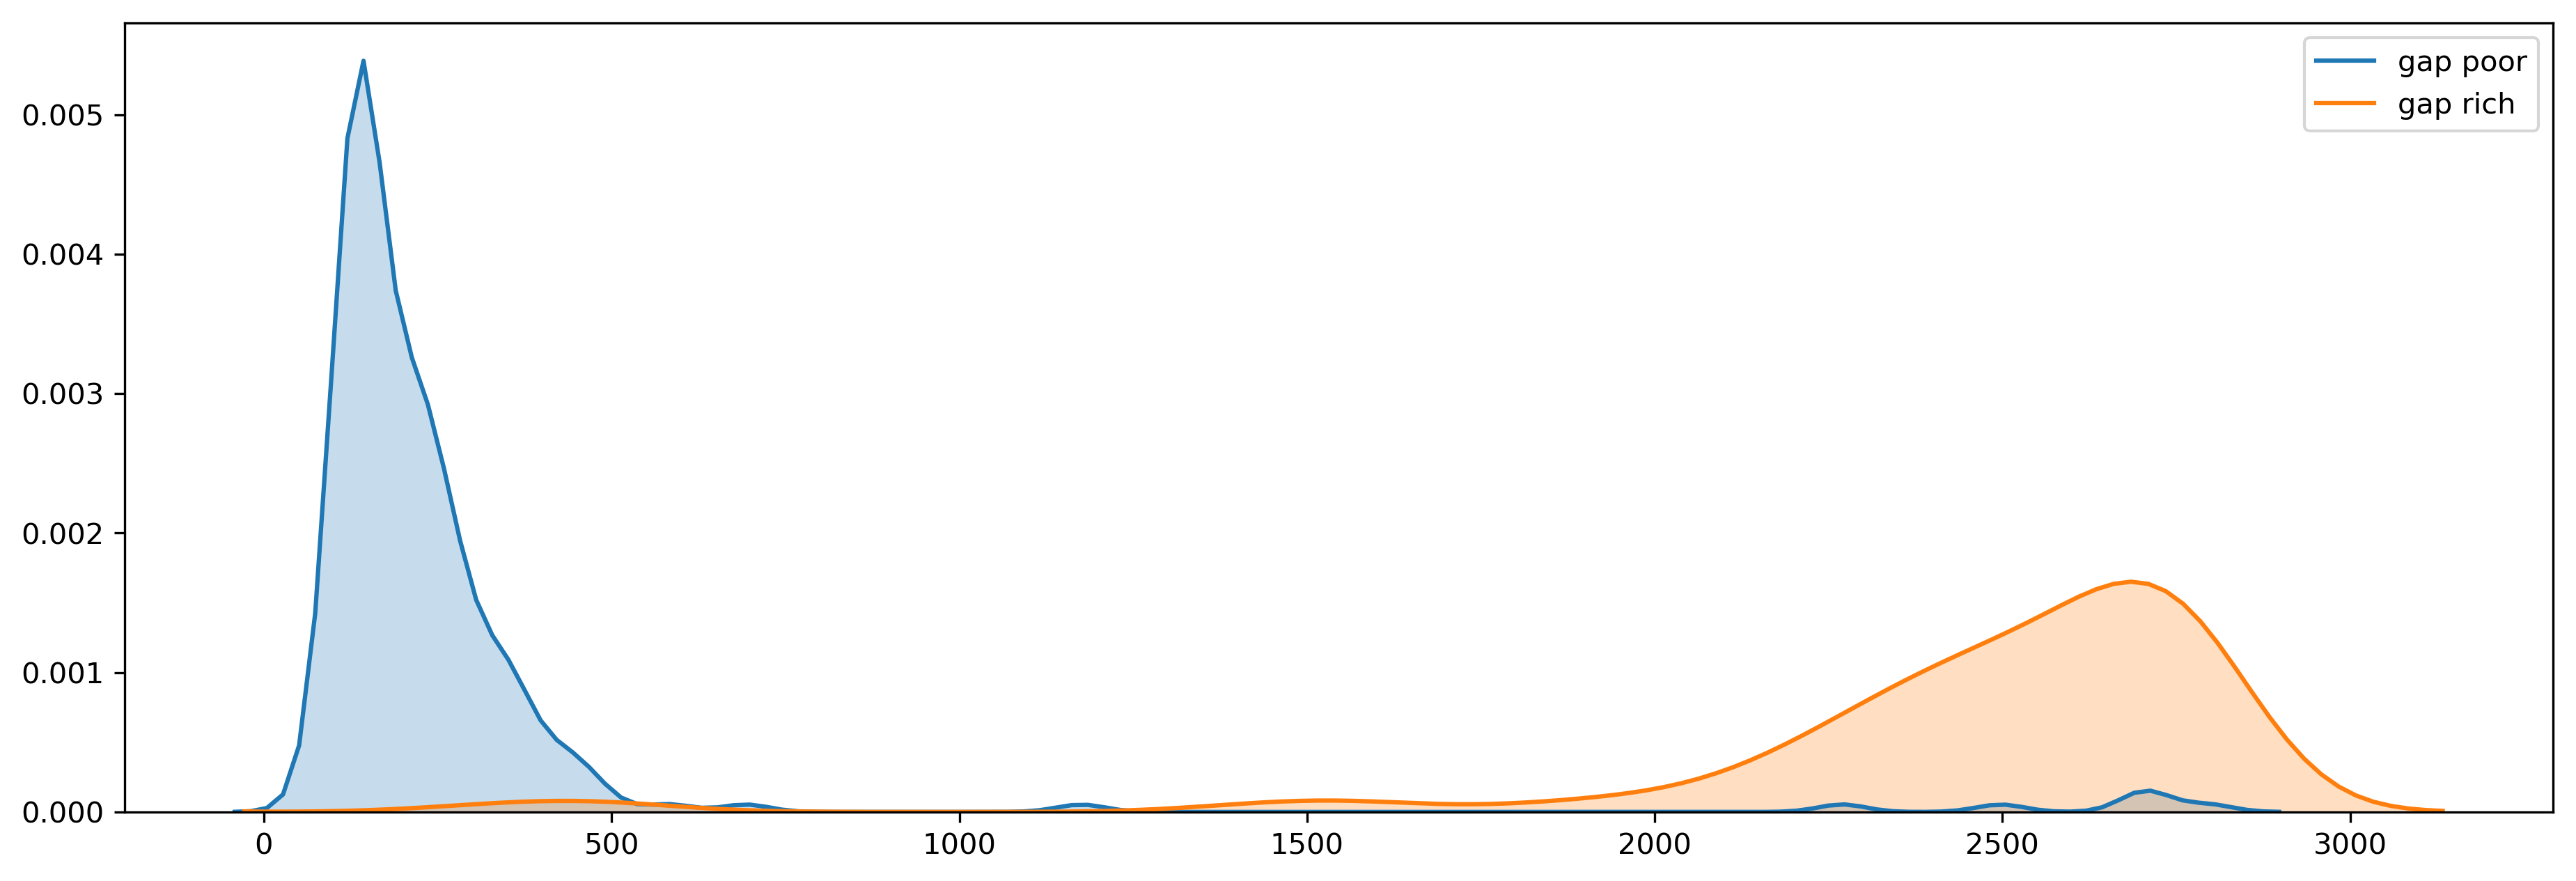

In [5]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
sns.kdeplot(number_of_gaps[well_aligned], label='gap poor', shade=True, ax=ax)
sns.kdeplot(number_of_gaps[bad_aligned], label='gap rich', shade=True, ax=ax)

In [5]:
len(well_aligned), len(bad_aligned), len(all_columns)

(217, 105, 466)

In [16]:
random.seed(12345)
#well_aligned = random.sample(well_aligned, len(bad_aligned))
#control = random.sample(all_columns, len(bad_aligned))
while len(well_aligned) < len(all_columns):
    well_aligned += well_aligned
while len(bad_aligned) < len(all_columns):
    bad_aligned += bad_aligned

fasta = open('gap_rich_VS_gap_poor/longer_sequences/%i_or_faster-gap_rich.aln' % threshold_cat, 'w')
for index, row in zip(headers, alignment):
    fasta.write('>%s\n%s\n' % 
                (index,
                 ''.join(row[bad_aligned[:len(all_columns)]])))
fasta.close()

fasta = open('gap_rich_VS_gap_poor/longer_sequences/%i_or_faster-gap_poor.aln' % threshold_cat, 'w')
for index, row in zip(headers, alignment):
    fasta.write('>%s\n%s\n' % 
                (index,
                 ''.join(row[well_aligned[:len(all_columns)]])))
fasta.close()

fasta = open('gap_rich_VS_gap_poor/longer_sequences/%i_or_faster.aln' % threshold_cat, 'w')
for index, row in zip(headers, alignment):
    fasta.write('>%s\n%s\n' % 
                (index,
                 ''.join(row[all_columns])))
fasta.close()

In [38]:
%cd /work/site_rate/hug_et_al/gap_rich_VS_gap_poor/longer_sequences

os.system('iqtree -rf ../../ribosomal_concat_ml_tree.tre -t 10_or_faster.aln.ufboot')
os.system('iqtree -rf ../../ribosomal_concat_ml_tree.tre -t 10_or_faster-gap_poor.aln.ufboot')
os.system('iqtree -rf ../../ribosomal_concat_ml_tree.tre -t 10_or_faster-gap_rich.aln.ufboot')

/work/site_rate/hug_et_al/gap_rich_VS_gap_poor/longer_sequences


0

/work/site_rate/hug_et_al/gap_rich_VS_gap_poor


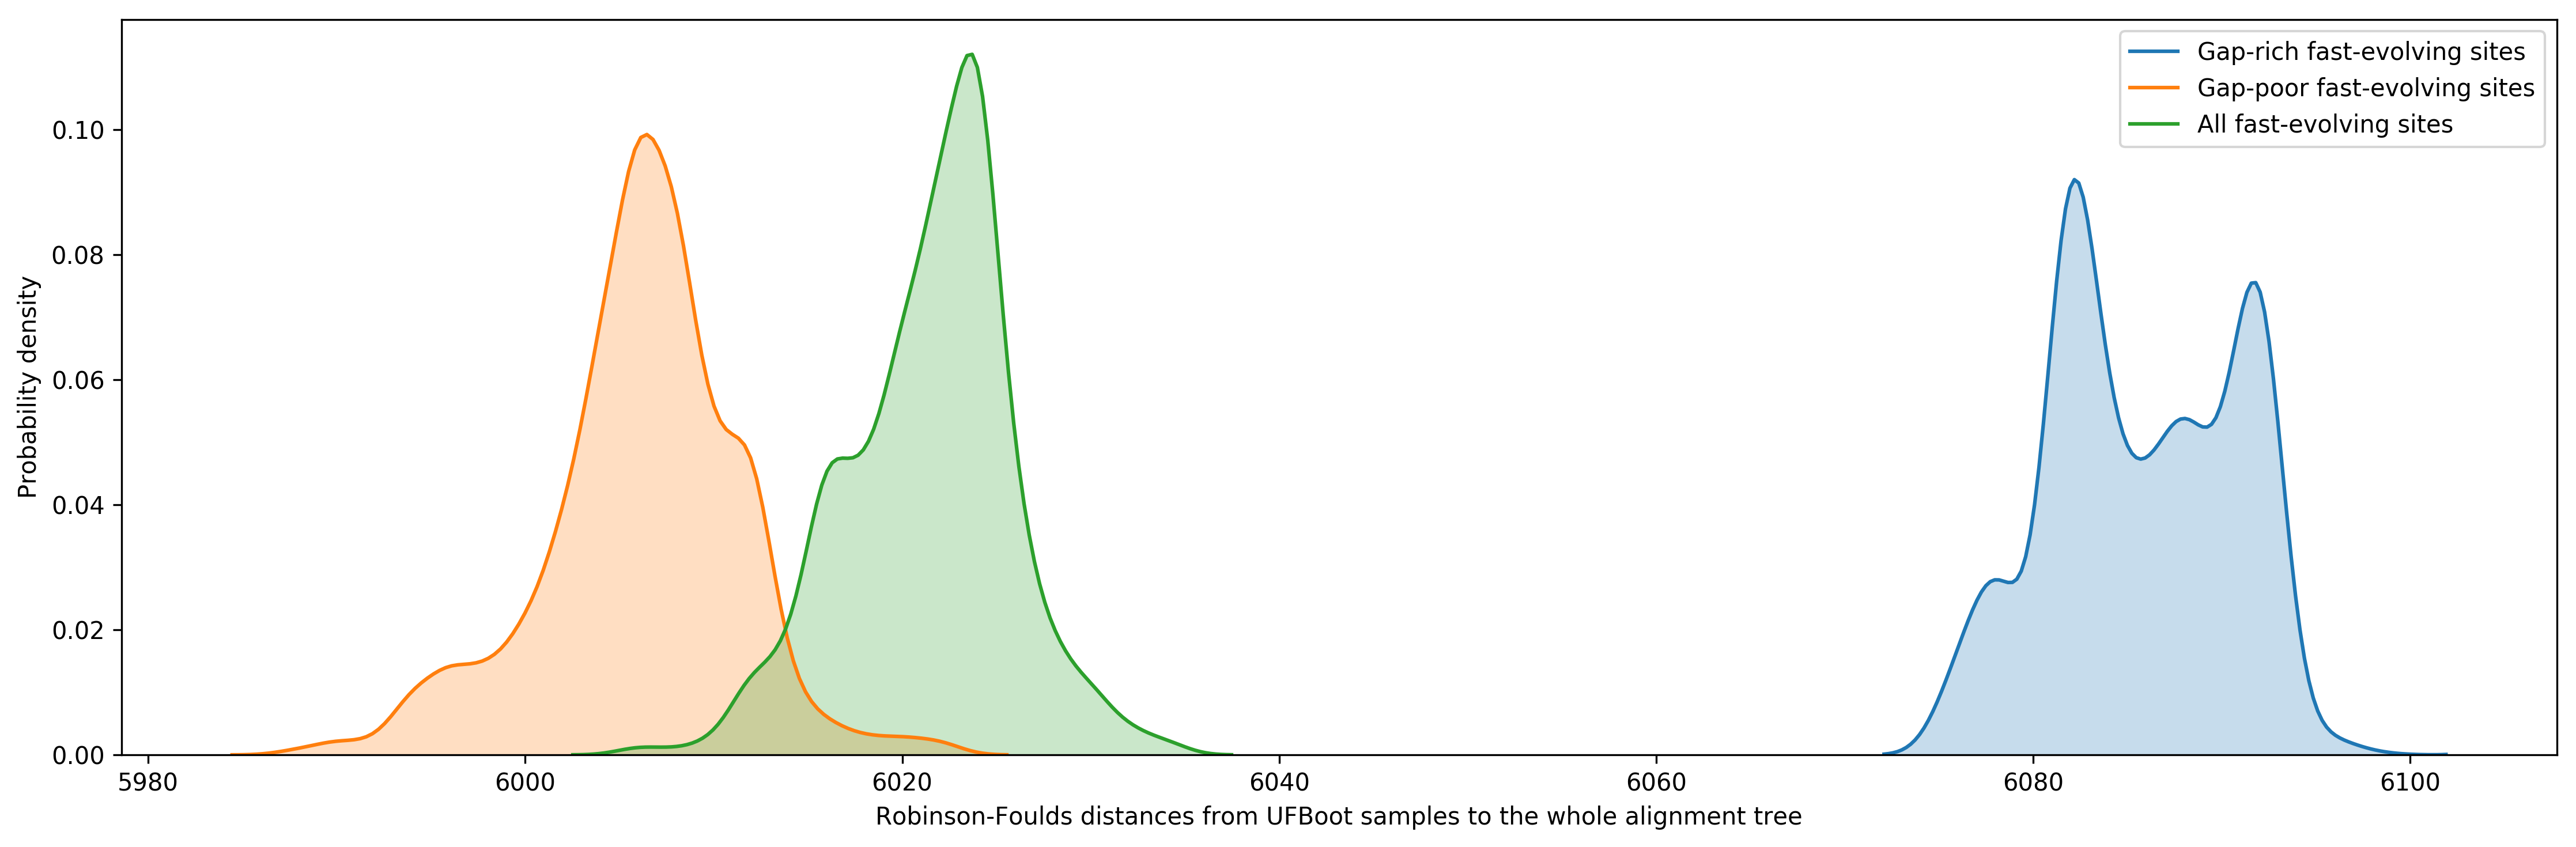

In [40]:
%cd /work/site_rate/hug_et_al/gap_rich_VS_gap_poor
fig, ax = plt.subplots(figsize=(15,5), dpi=300)
sns.kdeplot(
    [int(line.split()[1]) for line in open('10_or_faster-gap_rich.aln.ufboot.rfdist').readlines()[1:]],
    shade=True,
    label='Gap-rich fast-evolving sites',
    ax=ax
)
sns.kdeplot(
    [int(line.split()[1]) for line in open('10_or_faster-gap_poor.aln.ufboot.rfdist').readlines()[1:]],
    shade=True,
    label='Gap-poor fast-evolving sites',
    ax=ax
)
sns.kdeplot(
    [int(line.split()[1]) for line in open('10_or_faster.aln.ufboot.rfdist').readlines()[1:]],
    shade=True,
    label='All fast-evolving sites',
    ax=ax
)
ax.set_xlabel('Robinson-Foulds distances from UFBoot samples to the whole alignment tree')
ax.set_ylabel('Probability density')
fig.tight_layout()
fig.savefig('/Users/thiberio/Dropbox (MIT)/site_rates-paper/final figures/Figure 3.pdf')

In [27]:
rates         = pd.read_csv('rate_binning.rate', sep='\t', comment='#')
threshold_cat = 10

number_of_gaps = []
well_aligned   = []
all_columns    = []
for (index, row), (column, site) in zip(rates.iterrows(), enumerate(alignment.T)):
    number_of_gaps.append(sum(site=='-'))
    all_columns.append(column)

    if row.Cat < threshold_cat:
        well_aligned.append(column)
        continue
    
    if sum(alignment[:,column-1]=='-') <= 500 and sum(alignment[:,column+1]=='-') <= 500:
        well_aligned.append(column)
number_of_gaps = np.asarray(number_of_gaps)

rates          = rates.reindex(well_aligned)

In [30]:
os.chdir('/work/site_rate/hug_et_al')

alignment           = AlignIO.read('ribosomal_concat.fasta', 'fasta')
full_sequences      = {}
assessed_categories = [5,6,7,8,9,10,11,12]

selected_categories = rates[rates.Cat.isin(assessed_categories)]
out = open('selected_categories/no_slow_evolving_no_gappy_sites.aln', 'w')
for sequence in alignment:
    out.write('>{header}\n{sequence}\n'.format(
        header=sequence.name,
        sequence=''.join([sequence[position] for position in selected_categories.index])
    ))
out.close()